Text(0, 0.5, 'Pulse Amplitude: Correlates to E')

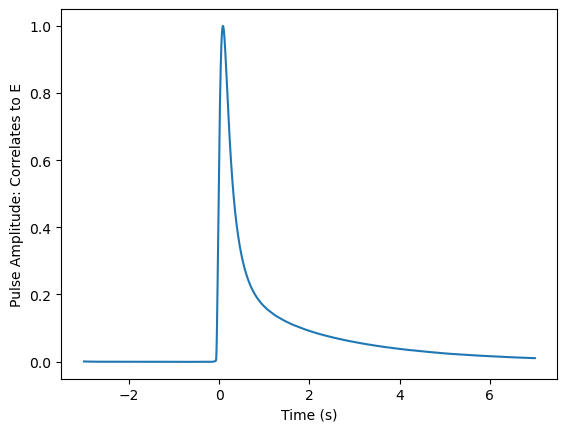

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot as up
tower2p1_events=pd.read_csv("pulse_out/Tower2p1_event_info.csv") #contains reconstruction information
pulses_tower2p1=up.concatenate(["pulse_out/Run352044_tower2p1.root:tree"],library='np')['samples'] #pulses
event_nums_tower2p1=up.concatenate(["pulse_out/Run352044_tower2p1.root:tree"],library='np')['event_number'] #event numbers to connect pulses to reconstruction info

ADC2mV=8.0108642578125e-02 ##this number should be checked with up-to-date front end board readings, but is fine for now
tower2p1_events
tower2p1_events["Channel"].unique()
CHANNEL=60 #hard-coding this for now...
file=open("average_pulse_dump/Channel00"+str(CHANNEL)+"_AveragePulse.txt")
for line in file:
    parse=line.replace("fData  ","")
    parse=parse.replace("\n","")
    splits=parse.split(" ")
    avg_pulse=np.array(splits,dtype=float)
    break

cleaned_avg_pulse=(avg_pulse-np.mean(avg_pulse[0:50]))/np.max(avg_pulse-np.mean(avg_pulse[0:50]))
#check out what normalized average pulse for channel 60 is

fully_sampled_times=np.linspace(-3,7,10000) #seconds

plt.plot(fully_sampled_times,cleaned_avg_pulse)

plt.xlabel("Time (s)")
plt.ylabel("Pulse Amplitude: Correlates to E")


1123.4049474985482  keV


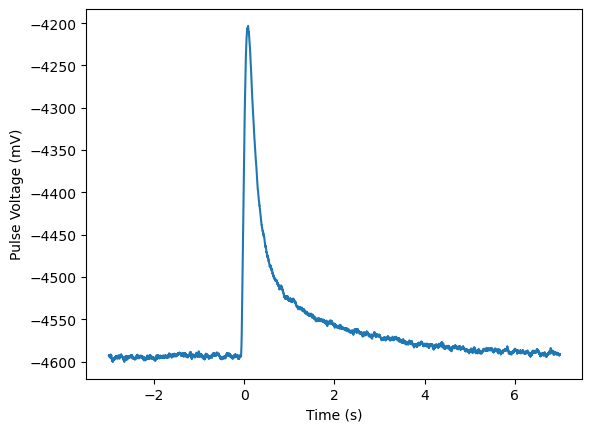

In [4]:
THIS_PULSE=8272 #pulse we'll focus on, to get nODE working
#check info on it...

#how to pass back & forth between event number & pulse id...
tower2p1_events[tower2p1_events['event_number']==event_nums_tower2p1[THIS_PULSE]]
THIS_ENERGY=tower2p1_events[tower2p1_events['event_number']==event_nums_tower2p1[THIS_PULSE]].iloc[0]['Energy']
plt.plot(np.linspace(-3,7,10000),ADC2mV*pulses_tower2p1[THIS_PULSE])

plt.xlabel("Time (s)")
plt.ylabel("Pulse Voltage (mV)")

print(THIS_ENERGY, " keV")

In [5]:
ch60_pulses=pulses_tower2p1[tower2p1_events['Channel']==60]
ch60_events=tower2p1_events[tower2p1_events['Channel']==60]

pick_pulse=31 # which pulse you want on the channel, between 0 & len(ch60_pulses)-1. I'm randomly choosing 32 here
this_pulse=ch60_pulses[pick_pulse] #voltage values for the pulse timestream
pulse_info=ch60_events.iloc[pick_pulse] #info for that pulse. need to access through iloc to correspond to same order as the pulse timestream\

pulse1, pulse2, pulse3 = ch60_pulses[29], ch60_pulses[30], ch60_pulses[31]

In [6]:
pulse1 = pulse1 + np.min(pulse1)*-1
pulse2 = pulse2+ np.min(pulse2)*-1
pulse3 = pulse3 + np.min(pulse3)*-1

pulse1 = pulse1/10000
pulse2 = pulse2/10000
pulse3 = pulse3/10000

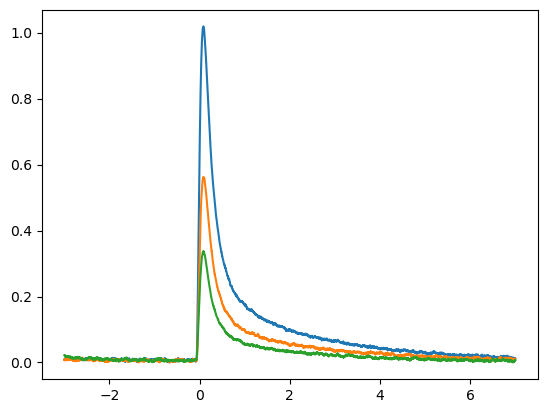

In [7]:
plt.plot(np.linspace(-3,7,10000),pulse1)
plt.plot(np.linspace(-3,7,10000),pulse2)
plt.plot(np.linspace(-3,7,10000),pulse3)

In [8]:
energies = [pulse1, pulse2, pulse3]
times = [np.linspace(-3,7,10000), np.linspace(-3,7,10000), np.linspace(-3,7,10000)]

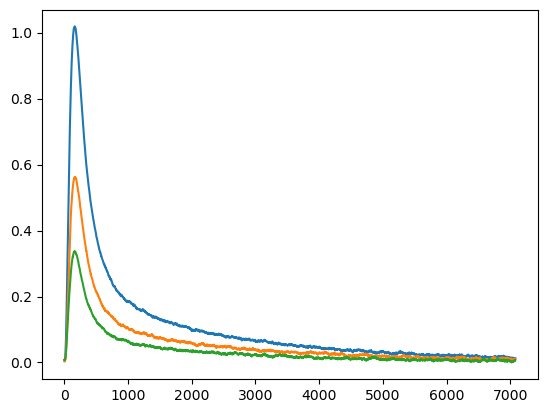

In [9]:
plt.plot(energies[0][2920:])
plt.plot(energies[1][2920:])
plt.plot(energies[2][2920:])

In [10]:
energies[0] = energies[0][2920:]
times[0] =  times[0][2920:]

energies[1] = energies[1][2920:]
times[1] =  times[1][2920:]

energies[2] = energies[2][2920:]
times[2] =  times[2][2920:]



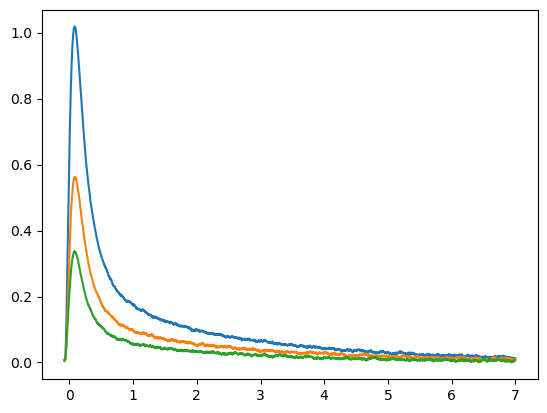

In [11]:
plt.plot(times[0],energies[0])
plt.plot(times[1],energies[1])
plt.plot(times[2],energies[2])

In [12]:
import numpy as np 
import pandas as pd 

import optax
import matplotlib.pyplot as plt
from typing import List
import equinox as eqx
import jax
import jax.numpy as jnp
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

In [13]:
length = len(energies[0])

In [14]:
energies[1]
jnp.array(energies[1])/np.max(energies[0])

Array([0.00549774, 0.00392696, 0.00274887, ..., 0.01197722, 0.01197722,
       0.01158453], dtype=float32)

In [15]:
energies[0] = jnp.array(energies[0])/np.max(energies[0])
times[0] = jnp.array(times[0])

energies[1] = jnp.array(energies[1])/np.max(energies[0])
times[1] = jnp.array(times[1])

energies[2] = jnp.array(energies[2])/np.max(energies[0])
times[2] = jnp.array(times[2])

data = [(energies[0], times[0]), (energies[1], times[1]), (energies[2], times[2])]


In [16]:
vars = [0, 10, 0]

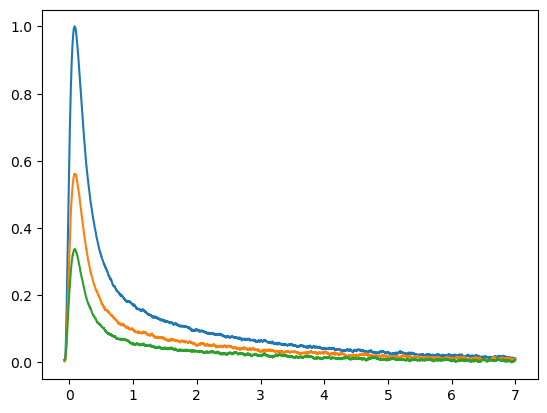

In [17]:
plt.plot(data[0][1], data[0][0])
plt.plot(data[1][1], data[1][0])
plt.plot(data[2][1], data[2][0])

In [21]:
import math
def model_to_loss(model, y_s, z_s, t_s, max_energy):
    # Solve the differential equation
    
    #print(type(t_s[0]))
    #print("MODELTOLOSS", y_s[0], z_s[0], t_s[len[t_s]])
    solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(model),
        diffrax.Tsit5(),
        t0=t_s[0],
        t1=t_s[-1],
        dt0=0.001,
        y0=jnp.array([0, max_energy, 0], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(t_s)),
    )
    
    y = solutions.ys[:length, 0]
    a =  solutions.ys[:length-1, 1]
    b =  solutions.ys[:length-1, 2]
     
    #print(solutions.ys[:length-1, 3])
    
    # Use nan_to_num to handle NaNs
    y = jnp.nan_to_num(y, nan=0.0)
   
   
    # Calculate squared differences for the loss
    y_diff = ((y - y_s[:length]) ** 2)
    #z_diff = (z - z_s[:N_SAMPLES-1]) ** 2
   # print(jnp.mean(y_diff) + jnp.mean(z_diff))
   # return jnp.sqrt(jnp.mean(y_diff))

   # Predicted outputs
   # print(y.shape, solutions.ys.shape)
    all_outputs = solutions.ys

   
    y_diff = (y - y_s[:length]) ** 2
    squared_loss = jnp.mean(y_diff)

    #print(all_outputs[0].shape)
    zero_input = jnp.zeros_like(all_outputs[-1])
    zero_output = model(0, zero_input)  
    equilibrium_loss = jnp.mean(jnp.abs(zero_output) ** 2)

    #print(np.sum(max_energy - solutions.ys[:length-1, 3]).item)
    #l2_loss = reg_lambda * sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(model) if p.ndim > 0)
    total_loss = (squared_loss + equilibrium_loss)
    return total_loss

In [22]:
class LinearFunction(eqx.Module):
    layers: list

    def __init__(self, key): 
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)
        self.layers = [eqx.nn.Linear(3,8, key = key1, use_bias=True), 
                       eqx.nn.Linear(8,3, key = key2, use_bias=True)] 
    def __call__(self, t, y, *args):
    
        for layer in self.layers[:-1]:
            y = jax.nn.tanh(layer(y))
        y = self.layers[-1](y)

        return y

In [34]:
z_s = z_s = np.linspace(0, 4, length)
model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)
opt = optax.rmsprop(learning_rate=0.003)
key = jax.random.PRNGKey(41)
key, subkey = jax.random.split(key, 2)
"""def custom_schedule(step):
    # Decrease learning rate as the step increases
    return jnp.maximum(0.001, 0.009 * (0.90 ** (step / 10000000)))  # Cap at 0.001

opt = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_schedule(custom_schedule)
)"""


def make_step(m, opt_s, y_s, z_s, t_s, max_energy):
    loss, grad = model_to_loss_and_grad(eqx.filter(m, eqx.is_inexact_array), y_s, z_s, t_s, max_energy)

    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

loss_history = []
MODEL = LinearFunction(subkey)
best_loss = float('inf')
opt_state = opt.init(eqx.filter(MODEL, eqx.is_array))

print("1")
for epoch in range(10000):
    MODEL, opt_state, loss = make_step(MODEL, opt_state, energies[0], z_s, times[0], max(energies[0]))
    loss_history.append(loss)
    MODEL, opt_state, loss = make_step(MODEL, opt_state, energies[1], z_s, times[1], max(energies[1]))
    loss_history.append(loss)
    MODEL, opt_state, loss = make_step(MODEL, opt_state, energies[2], z_s, times[2], max(energies[2]))
    loss_history.append(loss)
   
     # Log every 100 epochs
    print(f"Epoch {epoch}, Loss {loss}")

1


/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_4471/1391807300.py:13: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0, max_energy, 0], dtype=jnp.float64),


Epoch 0, Loss 0.05381225794553757
Epoch 1, Loss 0.009421063587069511
Epoch 2, Loss 0.007699223235249519
Epoch 3, Loss 0.006745219696313143
Epoch 4, Loss 0.006098073907196522
Epoch 5, Loss 0.005646438803523779
Epoch 6, Loss 0.005333534441888332
Epoch 7, Loss 0.005124466493725777
Epoch 8, Loss 0.004994759801775217
Epoch 9, Loss 0.004925529472529888
Epoch 10, Loss 0.0049010529182851315
Epoch 11, Loss 0.004907173570245504
Epoch 12, Loss 0.00493057444691658
Epoch 13, Loss 0.004960361402481794
Epoch 14, Loss 0.004991776309907436
Epoch 15, Loss 0.005026809871196747
Epoch 16, Loss 0.005069076083600521
Epoch 17, Loss 0.005122399423271418
Epoch 18, Loss 0.005186095833778381
Epoch 19, Loss 0.00525006465613842
Epoch 20, Loss 0.005261344835162163
Epoch 21, Loss 0.005151408724486828
Epoch 22, Loss 0.00490886066108942
Epoch 23, Loss 0.004661836661398411
Epoch 24, Loss 0.004498049151152372
Epoch 25, Loss 0.00441323546692729
Epoch 26, Loss 0.004374789539724588
Epoch 27, Loss 0.0043622152879834175
Epoch

In [25]:
min(loss_history)

Array(9.777046e-05, dtype=float32)

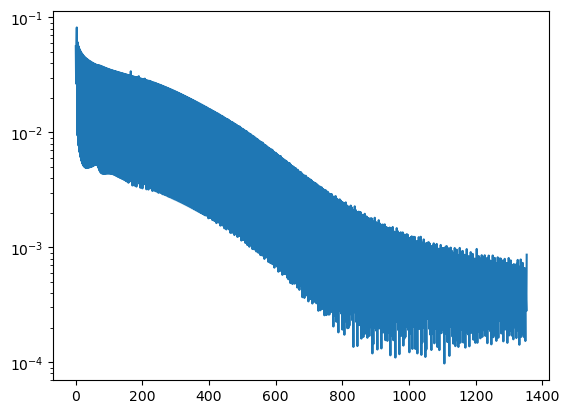

In [26]:
plt.plot(loss_history)
plt.yscale('log')

In [27]:
solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(MODEL),
        diffrax.Tsit5(),
        t0=float(times[0][0]),
        t1=float(times[0][-1]),
        dt0=0.01,
        y0=jnp.array([0,max(energies[0]) , 0], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(times[0])),
    )
print(solutions.ys[:, 0])

solutions2 = diffrax.diffeqsolve(
        diffrax.ODETerm(MODEL),
        diffrax.Tsit5(),
        t0=float(times[0][0]),
        t1=float(times[0][-1]),
        dt0=0.01,
        y0=jnp.array([0,max(energies[1]) , 0], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(times[0])),
    )
print(solutions.ys[:, 0])


solutions3 = diffrax.diffeqsolve(
        diffrax.ODETerm(MODEL),
        diffrax.Tsit5(),
        t0=float(times[0][0]),
        t1=float(times[0][-1]),
        dt0=0.01,
        y0=jnp.array([0,max(energies[2]), 0], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(times[0])),
    )
print(solutions.ys[:, 0])



/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_4471/1389652854.py:7: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0,max(energies[0]) , 0], dtype=jnp.float64),


[0.         0.00799733 0.01598348 ... 0.02045242 0.02044902 0.02044563]
[0.         0.00799733 0.01598348 ... 0.02045242 0.02044902 0.02044563]
[0.         0.00799733 0.01598348 ... 0.02045242 0.02044902 0.02044563]


/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_4471/1389652854.py:19: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0,max(energies[1]) , 0], dtype=jnp.float64),
/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_4471/1389652854.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0,max(energies[2]), 0], dtype=jnp.float64),


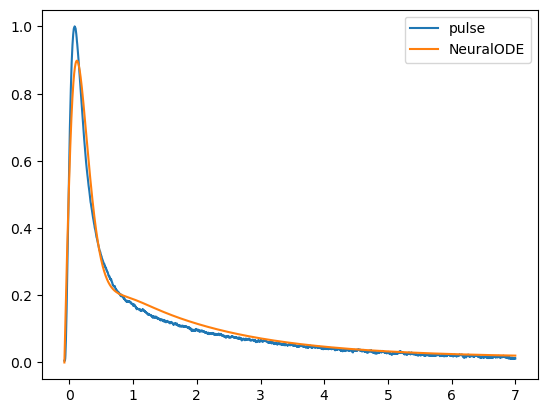

In [28]:
plt.plot(times[0], energies[0], label = "pulse")

plt.plot(times[0], solutions.ys[:, 0], label = "NeuralODE")
#plt.plot(time, energies-solutions.ys[:, 0])

plt.legend()

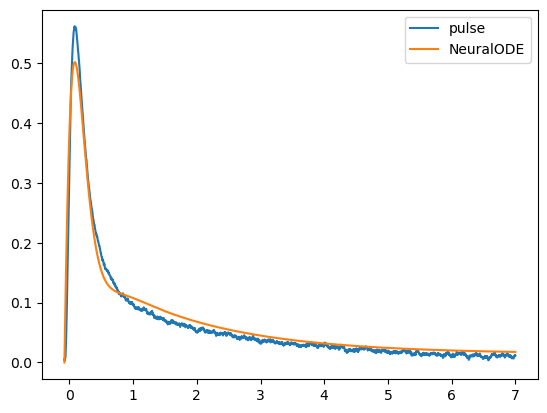

In [32]:
plt.plot(times[0], energies[1], label = "pulse")

plt.plot(times[0], solutions2.ys[:, 0], label = "NeuralODE")
#plt.plot(time, energies-solutions.ys[:, 0])

plt.legend()

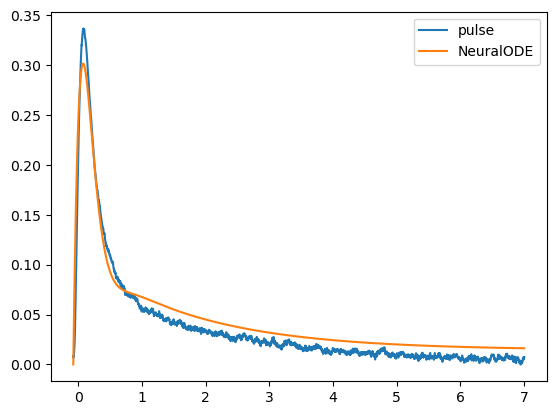

In [33]:
plt.plot(times[0], energies[2], label = "pulse")

plt.plot(times[0], solutions3.ys[:, 0], label = "NeuralODE")
#plt.plot(time, energies-solutions.ys[:, 0])

plt.legend()

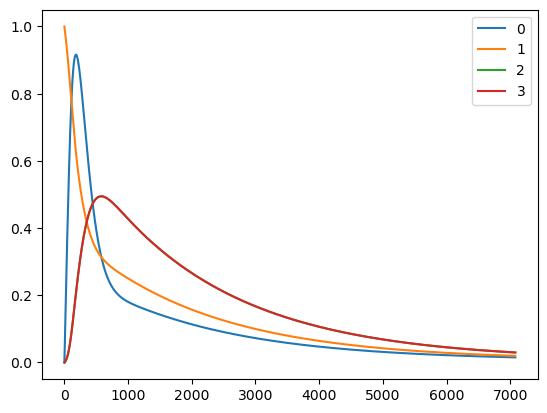

In [ ]:
plt.plot(solutions.ys[:, 0], label = "0")
plt.plot(solutions.ys[:, 1], label = "1")
plt.plot(solutions.ys[:, 2], label = "2")
plt.plot(solutions.ys[:, 3], label = "3")



plt.legend()

In [ ]:

solutions.ys[:, 3][0].item()


1.0